In [1]:
import numpy as np 
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
ticker = 'AAPL'
df = yf.download(ticker, '2020-01-01')

C:\Users\Dawit\AppData\Local\Temp\ipykernel_8884\2867026071.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [4]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.538513,72.598892,71.292304,71.545890,135480400
2020-01-03,71.833305,72.594071,71.608700,71.765682,146322800
2020-01-06,72.405670,72.444313,70.703005,70.954181,118387200
2020-01-07,72.065147,72.671341,71.845369,72.415337,108872000
2020-01-08,73.224403,73.526295,71.768079,71.768079,132079200
...,...,...,...,...,...
2025-08-22,227.759995,229.089996,225.410004,226.169998,42477800
2025-08-25,227.160004,229.300003,226.229996,226.479996,30983100


<Axes: xlabel='Date'>

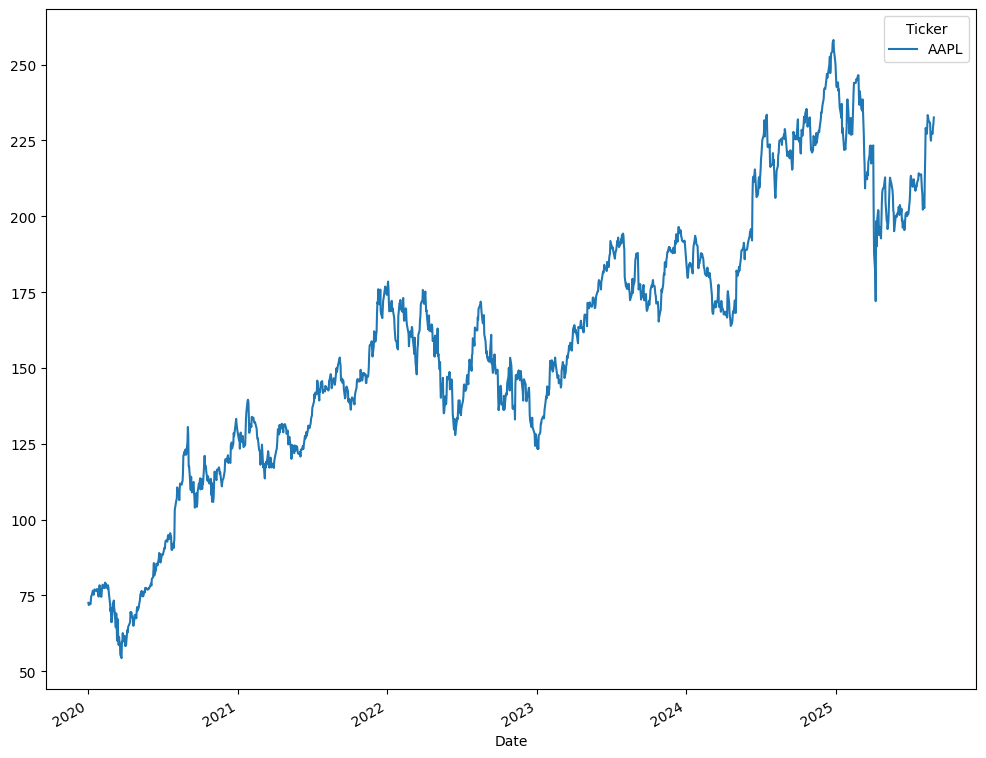

In [5]:
df.Close.plot(figsize=(12, 10))

In [6]:
scaler = StandardScaler()
df["Close"] = scaler.fit_transform(df['Close'])
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.933594
2020-01-03,-1.949319
2020-01-06,-1.936556
2020-01-07,-1.944149
2020-01-08,-1.918300
...,...
2025-08-22,1.527585
2025-08-25,1.514206
2025-08-26,1.562147


In [7]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])
data = np.array(data)


In [8]:
data

array([[[-1.93359371],
        [-1.94931866],
        [-1.93655588],
        ...,
        [-1.8257873 ],
        [-1.78481513],
        [-1.79739298]],

       [[-1.94931866],
        [-1.93655588],
        [-1.94414897],
        ...,
        [-1.78481513],
        [-1.79739298],
        [-1.79696104]],

       [[-1.93655588],
        [-1.94414897],
        [-1.91829951],
        ...,
        [-1.79739298],
        [-1.79696104],
        [-1.82908003]],

       ...,

       [[ 1.10643532],
        [ 1.12982209],
        [ 1.12670374],
        ...,
        [ 1.46381136],
        [ 1.52758457],
        [ 1.51420578]],

       [[ 1.12982209],
        [ 1.12670374],
        [ 1.15254027],
        ...,
        [ 1.52758457],
        [ 1.51420578],
        [ 1.56214703]],

       [[ 1.12670374],
        [ 1.15254027],
        [ 1.18149515],
        ...,
        [ 1.51420578],
        [ 1.56214703],
        [ 1.58845923]]], shape=(1392, 30, 1))

In [9]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)


In [10]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out
    

In [11]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [14]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 24 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.0037497873418033123
24 0.0035828992258757353
48 0.0035003807861357927
72 0.0034727866295725107
96 0.0034618903882801533
120 0.0034550989512354136
144 0.0034502262715250254
168 0.0034462411422282457
192 0.0034426122438162565
